## Import libraries

In [100]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from keras.applications import vgg16 as vgg
from tensorflow.keras.utils import load_img, img_to_array, to_categorical
import matplotlib.pyplot as plt
import os
from glob import glob
from sklearn.model_selection import train_test_split
import random
import cv2
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import matplotlib.image as mpimg
from keras.preprocessing import image
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE

SEED = 42

# Reading ABT and Rename Variables

In [101]:
# Read Google Drive 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [102]:
# Read abt

df = pd.read_csv('/content/drive/My Drive/TCC_FIA_IA/base_abt_modelagem.csv', index_col=0)
df

,Item,venfis,venfin,itens,itens_dist,datas,estoque,recencia,revendeu_prox_mes,ref_prev
0,-,3,127.50,1,1,28.0,0.0,156,0,2021-09-01
1,11ER030M D=3,3,27.52,1,1,28.0,0.0,113,0,2021-09-01
2,11ER040M D=4,10,27.52,1,1,28.0,0.0,113,0,2021-09-01
3,11ER060M D=6,10,27.52,1,1,28.0,0.0,113,0,2021-09-01
4,11IRAG60 (RT11 01NA60 YBG205),10,44.82,1,1,28.0,0.0,6,0,2021-09-01
...,...,...,...,...,...,...,...,...,...,...
2648,XNGU100408ERML WU10PM,10,40.00,1,1,28.0,0.0,180,0,2022-02-01
2649,XNGU100408ERML WU10PM,20,46.62,1,1,35.0,20.0,267,0,2022-02-01
2650,XNGU100408ERML WU10PM,10,29.43,1,1,28.0,40.0,316,0,2022-02-01
2651,XNGU15T608ERALP WN25PM,10,125.00,1,1,35.0,0.0,313,0,2022-02-01


In [103]:
# Rename variables

key_vars = ['ref_prev', 'Item']

num_vars = ['venfis', 'venfin', 'itens', 'itens_dist', 'datas', 'estoque', 'recencia']

target = 'revendeu_prox_mes'

cat_vars = []

features = num_vars+cat_vars

In [104]:
# Function to standardscale data
def preprocess(features, target, test_size1 = 0.2, test_size2 = 0.1):
    global X, y, X_train, y_train, X_test, y_test, X_valid, y_valid, y_test2
    X = features
    y = target
    
    # train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size1, random_state=SEED)

    # validation data
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=test_size2, random_state=SEED)

    
    scaler = StandardScaler()
    # X_train para padronizar os dados, primeiro preciso jogar para o formato de matriz, e depois voltar para o padrão antigo, lembrando que tupla precisa
    # ser passado com o simbolo *(x, y, z)
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)
    X_valid = scaler.fit_transform(X_valid)
    y_train2 = np.array(y_train)
    y_train = np.array(to_categorical(y_train, 2))
    y_test2 = np.array(y_test)
    y_test = to_categorical(y_test, 2)
    y_valid = np.array(to_categorical(y_valid, 2))


    return X_train, y_train, X_test, y_test, X_valid, y_valid, y_test2, y_train2

In [105]:
X_train, y_train, X_test, y_test, X_valid, y_valid, y_test2, y_train2 = preprocess(features = df[features], target = df[target])

In [106]:
# function to smote data -> unbalanced data

def balancear_dados(X_train, y_train, random_state = 42, n_jobs = -1, sampling_strategy = 'all', k_neighbors = 1):
    global X_res, y_res
    sm = SMOTE(random_state = random_state, n_jobs = n_jobs, sampling_strategy = sampling_strategy, k_neighbors = k_neighbors)
    X_res, y_res = sm.fit_resample(X_train, y_train)
    y_res = to_categorical(y_res, 2)
    return X_res, y_res

In [107]:
X_res, y_res = balancear_dados(X_train = X_train, y_train = y_train)

In [108]:
# Function to stop model when there is no increase in auc metric
callback = tf.keras.callbacks.EarlyStopping(monitor='auc', patience=3)

In [109]:
fitted_model = None
model = None
tf.keras.backend.clear_session()

In [110]:
inits = X_train.shape[1]
model = Sequential()
model.add(Dense(X_train.shape[0], activation = 'relu', input_shape = (inits, )))
model.add(Dense(512, activation = 'relu'))
model.add(Dense(40, activation = 'relu'))

model.add(Dense(2, activation = 'sigmoid'))




model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = [tf.keras.metrics.AUC(from_logits=True)])


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 11786)             94288     
                                                                 
 dense_1 (Dense)             (None, 512)               6034944   
                                                                 
 dense_2 (Dense)             (None, 40)                20520     
                                                                 
 dense_3 (Dense)             (None, 2)                 82        
                                                                 
Total params: 6,149,834
Trainable params: 6,149,834
Non-trainable params: 0
_________________________________________________________________


In [111]:
history = model.fit(
    X_res,
    y_res,
    epochs = 150,
    verbose = 1,
    validation_data = (X_valid, y_valid),
    use_multiprocessing=True,
    callbacks = [callback]
)

Epoch 1/150
609/609 [==============================] - 4s 5ms/step - loss: 0.6197 - auc: 0.7144 - val_loss: 0.5888 - val_auc: 0.7695
Epoch 2/150
609/609 [==============================] - 3s 5ms/step - loss: 0.6025 - auc: 0.7344 - val_loss: 0.6195 - val_auc: 0.7372
Epoch 3/150
609/609 [==============================] - 3s 4ms/step - loss: 0.5956 - auc: 0.7433 - val_loss: 0.5491 - val_auc: 0.8108
Epoch 4/150
609/609 [==============================] - 3s 5ms/step - loss: 0.5928 - auc: 0.7450 - val_loss: 0.5707 - val_auc: 0.7781
Epoch 5/150
609/609 [==============================] - 3s 5ms/step - loss: 0.5887 - auc: 0.7483 - val_loss: 0.5560 - val_auc: 0.8108
Epoch 6/150
609/609 [==============================] - 3s 4ms/step - loss: 0.5861 - auc: 0.7499 - val_loss: 0.5524 - val_auc: 0.8099
Epoch 7/150
609/609 [==============================] - 3s 5ms/step - loss: 0.5841 - auc: 0.7509 - val_loss: 0.6092 - val_auc: 0.7422
Epoch 8/150
609/609 [==============================] - 3s 5ms/step - 

In [112]:
y_pred = np.argmax(model.predict(X_test), axis = 1)
y_pred

array([0, 0, 0, ..., 0, 1, 0])

In [119]:
score = model.evaluate(X_valid, y_valid, verbose = 0)
print('Test loss - Validation data', score[0])
print('Test AUC - Validation data', score[1])

Test loss - Validation data 0.6890989542007446
Test AUC - Validation data 0.8059384822845459


In [120]:
print(classification_report(y_test2, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.86      0.88      2189
           1       0.44      0.58      0.50       431

    accuracy                           0.81      2620
   macro avg       0.68      0.72      0.69      2620
weighted avg       0.83      0.81      0.82      2620



In [121]:
y_pred2 = model.predict(X_test)[:,1]
print(metrics.roc_auc_score(y_test2, y_pred2))
print(accuracy_score(y_test2, y_pred))
print(recall_score(y_test2, y_pred))
print(precision_score(y_test2, y_pred))

0.7413984073499749
0.8118320610687023
0.5754060324825986
0.4444444444444444


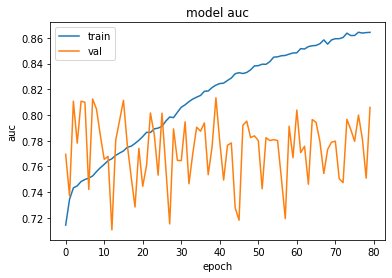

In [122]:
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [123]:
y_pred_train = np.argmax(model.predict(X_train), axis = 1)
y_pred_train

array([0, 0, 0, ..., 0, 0, 0])

In [124]:
print(accuracy_score(y_train2, y_pred_train))
print(recall_score(y_train2, y_pred_train))
print(precision_score(y_train2, y_pred_train))

0.8359918547429154
0.671692607003891
0.5233042819249716
